In [27]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Libraries and imports



In [28]:
!pip install annoy

In [29]:
!pip install tensorflow-addons

In [30]:
!pip install tensorflow-text

In [31]:
!pip install --upgrade tensorflow-hub

In [32]:
import tensorflow as tf
import numpy as np
import os
import random
import string
import re
import matplotlib.pyplot as plt
import keras.backend as K
import pandas as pd
import tensorflow_addons as tfa
import tensorflow_hub as hub
import tensorflow_text as tftx
import json

tfk = tf.keras
tfkl = tf.keras.layers
tf.config.optimizer.set_jit(True)
strategy = tf.distribute.get_strategy()

# Random seed for reproducibility

In [33]:
seed = 21
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Mixed precision


In [34]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None

if tpu:
  policyConfig = 'mixed_bfloat16'
else:
  policyConfig = 'mixed_float16'
policy = tf.keras.mixed_precision.Policy(policyConfig)
tf.keras.mixed_precision.set_global_policy(policy)

# Parameters

In [35]:
# Parameters

batch_size = 32
image_shape = (128, 128, 3)

# Train, Validation & Test Dataset

In [36]:
!unzip "/gdrive/My Drive/val2014_128.zip"

Archive:  /gdrive/My Drive/val2014_128.zip
replace val2014_128/COCO_val2014_000000000042.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [37]:
with open('/gdrive/My Drive/instances_val2014.json', 'r') as file:
    instances_val2014 = json.load(file)

categories={}
for c in instances_val2014["categories"]:
    categories[c["id"]]=c["name"]

name_images = set()

for l in instances_val2014["annotations"]:
    name_images.add(l["image_id"])

labels={}
for n in name_images:
    labels[n]=set()

for lab in instances_val2014["annotations"]:
    labels[lab["image_id"]].add(categories[lab["category_id"]])

path_folder_images = "/content/val2014_128/COCO_val2014_"
image_extension = ".jpg"

name_images = list(map(lambda x: path_folder_images + (str(x).zfill(12)) + image_extension, name_images))

In [38]:
def load_image(name_image):
    image = tf.io.read_file(name_image)
    image = tf.image.decode_jpeg(image, channels=3)
    image /= 255
    return image

def make_ds(name_image):
    return tf.data.Dataset.from_tensor_slices(name_image) \
        .map(load_image) \
        .batch(batch_size, drop_remainder=True)

ds = make_ds(name_images)

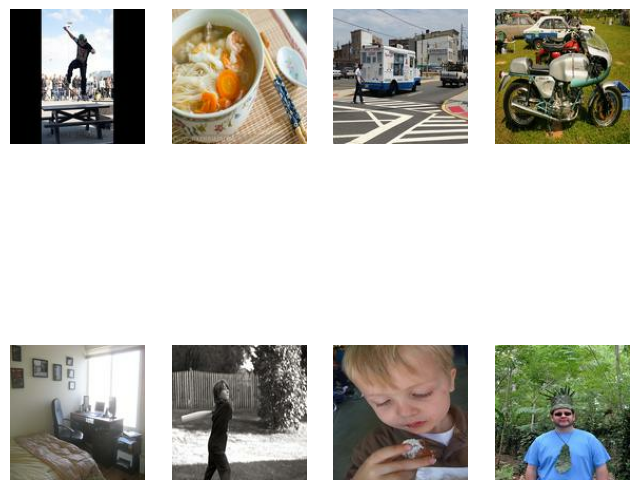

In [39]:
for i in ds.take(1):
  plt.figure(figsize=(8, 8))
  for index in range(8):
      plt.subplot(2, 4, index+1)
      plt.imshow(i[index], cmap='gray')
      plt.axis('off')

  plt.show()

# Load Encoders

In [40]:
image_encoder=tf.keras.models.load_model("/gdrive/MyDrive/test_image_weights_epoch_5")

In [41]:
caption_encoder=tf.keras.models.load_model("/gdrive/MyDrive/test_caption_weights_epoch_5")

#Image retrieval on a specific query


## Metrics

In [42]:
def precision_at_k(predictions, k):
    relevant_count = sum(predictions[:k])
    precision = relevant_count / k if k > 0 else 0
    return precision

def ndcg_at_k(predictions, k):
    dcg = predictions[0]
    for i in range(1, k):
        dcg += predictions[i] / np.log2(i + 1)

    ideal_predictions = sorted(predictions, reverse=True)
    ideal_dcg = ideal_predictions[0]
    for i in range(1, k):
        ideal_dcg += ideal_predictions[i] / np.log2(i + 1)

    ndcg = dcg / ideal_dcg if ideal_dcg > 0 else 0
    return ndcg

def mrr(predictions):
    for i, pred in enumerate(predictions):
        if pred == 1:
            return 1 / (i + 1)
    return 0

def recall_at_k(predictions, k, total_relevant_items):
    relevant_count = sum(predictions[:k])
    recall = relevant_count / total_relevant_items if total_relevant_items > 0 else 0
    return recall

def average_precision_at_k(predictions, k):
    relevant_count = sum(predictions[:k])
    if relevant_count == 0:
        return 0

    average_precision = 0
    true_positives = 0

    for i in range(k):
        if predictions[i] == 1:
            true_positives += 1
            precision = true_positives / (i + 1)
            average_precision += precision

    average_precision /= relevant_count
    return average_precision

In [43]:
def evaluation(relevants):
  k_value=1
  p_1 = precision_at_k(relevants, k_value)
  print(f"Precision@{k_value}: {p_1}")
  k_value=5
  p_5 = precision_at_k(relevants, k_value)
  print(f"Precision@{k_value}: {p_5}")
  k_value=10
  p_10 = precision_at_k(relevants, k_value)
  print(f"Precision@{k_value}: {p_10}")

  total_relevant_items = sum(relevants)
  k_value=1
  r_1 = recall_at_k(relevants, k_value, total_relevant_items)
  print(f"Recall@{k_value}: {r_1}")
  k_value=5
  r_5 = recall_at_k(relevants, k_value, total_relevant_items)
  print(f"Recall@{k_value}: {r_5}")
  k_value=10
  r_10 = recall_at_k(relevants, k_value, total_relevant_items)
  print(f"Recall@{k_value}: {r_10}")

  k_value=1
  ndcg_1 = ndcg_at_k(relevants, k_value)
  print(f"NDCG@{k_value}: {ndcg_1}")
  k_value=5
  ndcg_5 = ndcg_at_k(relevants, k_value)
  print(f"NDCG@{k_value}: {ndcg_5}")
  k_value=10
  ndcg_10 = ndcg_at_k(relevants, k_value)
  print(f"NDCG@{k_value}: {ndcg_10}")

  k_value=1
  ap_1 = average_precision_at_k(relevants, k_value)
  print(f"AP@{k_value}: {ap_1}")
  k_value=5
  ap_5 = average_precision_at_k(relevants, k_value)
  print(f"AP@{k_value}: {ap_5}")
  k_value=10
  ap_10 = average_precision_at_k(relevants, k_value)
  print(f"AP@{k_value}: {ap_10}")

  m = mrr(relevants)
  print(f"MRR: {m}")

  return p_1, p_5, p_10, r_1, r_5, r_10, ndcg_1, ndcg_5, ndcg_10, ap_1, ap_5, ap_10, m

## Image Embeddings

In [44]:
img_embeddings = image_encoder.predict(ds)

1254/1254 [==============================] - 20s 13ms/step


In [45]:
from annoy import AnnoyIndex

# Create an Annoy index
num_trees = 10  # Number of trees in the index
annoy_index = AnnoyIndex(768)  # Provide the dimension of your embeddings

# Add embeddings to the index
image_indices = []
for i, embedding in enumerate(img_embeddings):
    annoy_index.add_item(i, embedding)
    image_indices.append(i)

# Build the index
annoy_index.build(num_trees)

<ipython-input-45-3cf869a733ee>:5: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  annoy_index = AnnoyIndex(768)  # Provide the dimension of your embeddings


True

## Query embedding & Retrieval


In [46]:
query = "dog"

caption_embeds = caption_encoder.predict([query])

1/1 [==============================] - 2s 2s/step


In [47]:
# Query the index to find nearest neighbors
query_embedding = caption_embeds[0]  # Generate an embedding for your query
num_neighbors = len(name_images) # Number of neighbors to retrieve
nearest_indices = annoy_index.get_nns_by_vector(query_embedding, num_neighbors, search_k=-1)

# Retrieve original images using the nearest_indices
nearest_images = [image_indices[i] for i in nearest_indices]

# Identify the results as relevant or do not match the query
relevants = []
for image_num in nearest_images[0:10]:
    if (query in labels[int(name_images[image_num][38:-4])]):
        relevants.append(1)
    else:
        relevants.append(0)

In [48]:
# Iterate through the nearest image and display them
for image_num in nearest_images[:10]:
  image = tf.io.read_file(name_images[image_num])
  image = tf.image.decode_jpeg(image, channels=3)
  image /= 255
  plt.imshow(image)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Evaluation of metrics

In [49]:
evaluation(relevants)

Precision@1: 1.0
Precision@5: 1.0
Precision@10: 1.0
Recall@1: 0.1
Recall@5: 0.5
Recall@10: 1.0
NDCG@1: 1.0
NDCG@5: 1.0
NDCG@10: 1.0
AP@1: 1.0
AP@5: 1.0
AP@10: 1.0
MRR: 1.0


(1.0, 1.0, 1.0, 0.1, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)

# Information Retrivial on all 80 queries

In [50]:
P_1, P_5, P_10, R_1, R_5, R_10, NDCG_1, NDCG_5, NDCG_10, AP_1, AP_5, AP_10, MRR = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

for q in categories:

  query = categories[q]
  print("Query: ", query)

  query_embedding = caption_encoder.predict([query])

  # Query the index to find nearest neighbors
  nearest_indices = annoy_index.get_nns_by_vector(query_embedding[0], len(name_images), search_k=-1)

  # Retrieve original images using the nearest_indices
  nearest_images = [image_indices[i] for i in nearest_indices]

  # Identify the results as relevant or do not match the query
  relevants = []
  for image_num in nearest_images[0:10]:
      if (query in labels[int(name_images[image_num][38:-4])]):
          relevants.append(1)
      else:
          relevants.append(0)

  p_1, p_5, p_10, r_1, r_5, r_10, ndcg_1, ndcg_5, ndcg_10, ap_1, ap_5, ap_10, m = evaluation(relevants)
  P_1 += p_1
  P_5 += p_5
  P_10 += p_10
  R_1 += r_1
  R_5 += r_5
  R_10 += r_10
  NDCG_1 += ndcg_1
  NDCG_5 += ndcg_5
  NDCG_10 += ndcg_10
  AP_1 += ap_1
  AP_5 += ap_5
  AP_10 += ap_10
  MRR += m

Query:  person
1/1 [==============================] - 0s 42ms/step
Precision@1: 1.0
Precision@5: 1.0
Precision@10: 1.0
Recall@1: 0.1
Recall@5: 0.5
Recall@10: 1.0
NDCG@1: 1.0
NDCG@5: 1.0
NDCG@10: 1.0
AP@1: 1.0
AP@5: 1.0
AP@10: 1.0
MRR: 1.0
Query:  bicycle
1/1 [==============================] - 0s 52ms/step
Precision@1: 0.0
Precision@5: 0.6
Precision@10: 0.8
Recall@1: 0.0
Recall@5: 0.375
Recall@10: 1.0
NDCG@1: 0.0
NDCG@5: 0.5420802832028203
NDCG@10: 0.7812774989197036
AP@1: 0
AP@5: 0.5333333333333333
AP@10: 0.6635912698412698
MRR: 0.5
Query:  car
1/1 [==============================] - 0s 50ms/step
Precision@1: 1.0
Precision@5: 0.4
Precision@10: 0.4
Recall@1: 0.25
Recall@5: 0.5
Recall@10: 1.0
NDCG@1: 1.0
NDCG@5: 0.47909091485969846
NDCG@10: 0.6759956431585283
AP@1: 1.0
AP@5: 0.75
AP@10: 0.5583333333333333
MRR: 1.0
Query:  motorcycle
1/1 [==============================] - 0s 55ms/step
Precision@1: 1.0
Precision@5: 0.6
Precision@10: 0.8
Recall@1: 0.125
Recall@5: 0.375
Recall@10: 1.0
NDCG@1:

In [51]:
print(f"Precision@{1}: {P_1/len(categories)}")
print(f"Precision@{5}: {P_5/len(categories)}")
print(f"Precision@{10}: {P_10/len(categories)}")

print(f"Recall@{1}: {R_1/len(categories)}")
print(f"Recall@{5}: {R_5/len(categories)}")
print(f"Recall@{10}: {R_10/len(categories)}")

print(f"NDCG@{1}: {NDCG_1/len(categories)}")
print(f"NDCG@{5}: {NDCG_5/len(categories)}")
print(f"NDCG@{10}: {NDCG_10/len(categories)}")

print(f"MAP@{1}: {AP_1/len(categories)}")
print(f"MAP@{5}: {AP_5/len(categories)}")
print(f"MAP@{10}: {AP_10/len(categories)}")

print(f"MRR: {MRR/len(categories)}")

Precision@1: 0.5875
Precision@5: 0.5325
Precision@10: 0.545
Recall@1: 0.10105158730158732
Recall@5: 0.43194940476190496
Recall@10: 0.9
NDCG@1: 0.5875
NDCG@5: 0.5716929992700187
NDCG@10: 0.7007820700943083
MAP@1: 0.5875
MAP@5: 0.6424826388888893
MAP@10: 0.6204653053350969
MRR: 0.6847519841269843
